The purpose of this notebook is to generate articles paragraph by paragraph using the trained models. The articles will be generated using the existing paragraphs from the articles themselves, continuously evaluating and adding paragraphs. The query that is passed to the model is a tokenized version of the of the article that has been built up to that point, starting with the first paragraph.

In [1]:
! pip install trec-car-tools transformers
import torch
import sys
import collections
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional, CosineEmbeddingLoss, BCEWithLogitsLoss, CosineSimilarity, BCELoss
from torch.utils.data.dataset import Dataset
from trec_car import read_data
from cbor import *
from transformers import BertModel, BertTokenizer, BertForNextSentencePrediction, Trainer, TrainingArguments
import random
# model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
file = 'train.pages.cbor'

     |████████████████████████████████| 2.1MB 5.2MB/s 
     |████████████████████████████████| 901kB 24.6MB/s 
     |████████████████████████████████| 3.3MB 36.0MB/s 
  Created wheel for cbor: filename=cbor-1.0.0-cp37-cp37m-linux_x86_64.whl size=51259 sha256=85f2c9ace1cfc1666bbb294e77b38856d5e11b9ca8e3fd5815f41c3ede74546d
  Stored in directory: /root/.cache/pip/wheels/40/5c/a5/e6d629446a6a687ba328c55f1589234c29b99ef35b1a65dbaa
Successfully built cbor


In [2]:
pages = read_data.iter_pages(open(file, 'rb'))
page = next(pages)
# my_model = BertModel.from_pretrained('drive/MyDrive/thesis_models/bert/checkpoint-5928')
bertmodel = BertModel.from_pretrained('bert-base-uncased')
emb_model = BertModel.from_pretrained('drive/MyDrive/thesis_models/bert/cosine-EMB/checkpoint-988')
mrr_vals1 = []
mrr_vals4 = []
mrr_bert = []

In [ ]:
# my model 1
corpus = page.get_text().split('\n')
cos = CosineSimilarity(dim=1, eps=1e-6)

mrr_vals = []

output_file = 'out-batch-1.txt'
query = corpus.pop(0) # first para
out_text = query

pmodel_vals = []

# run each of the paragraphs through the model and save them
for p in corpus:
    pemb = tokenizer(p, return_tensors='pt', padding='max_length', max_length=128, truncation=True)['input_ids']
    pmodel = my_model(pemb)[0]
    pmodel_vals.append(pmodel)
    
# for each paragraph, compare it to the query and find the closest
count = 0
while len(corpus) != 0:
  qemb = tokenizer(query, return_tensors='pt', padding='max_length', max_length=128, truncation=True)['input_ids']
  qout = my_model(qemb)[0]

  # create a dictionary with keys as indecies and cosin similarity as values
  cos_vals = { i: cos(qout[0].type(torch.FloatTensor), pmodel_vals[i][0].type(torch.FloatTensor)).mean() for i in range(len(pmodel_vals)) }
  # get the order of the indecies
  ordered_ind = sorted(cos_vals, key=cos_vals.get)
  ordered_ind.reverse()
  rank_error = (1 / (ordered_ind.index(0) + 1))
  mrr_vals.append(rank_error)

  # print(corpus[ordered_ind[1]])
  # print(corpus[ordered_ind[2]])
  # print(ordered_ind)
  # print(cos_vals)
  # break

  next_para = corpus.pop(ordered_ind[0])
  pmodel_vals.pop(ordered_ind[0])
  query = query + next_para
  out_text = out_text + '\n' + next_para


  # if count == 3:
  #   print(next_para)
  #   break
  
  # count += 1

print(mrr_vals)
mrr_vals1 = mrr_vals
print(sum(mrr_vals) / len(mrr_vals))
# with open(output_file, 'w') as f:
#    print(out_text, file = f)


NameError: ignored

In [ ]:
# my model 4
corpus = page.get_text().split('\n')
cos = CosineSimilarity(dim=1, eps=1e-6)

mrr_vals = []

output_file = 'out-batch-4.txt'
query = corpus.pop(0) # first para
out_text = query

pmodel_vals = []


# run each of the paragraphs through the model and save them
for p in corpus:
    pemb = tokenizer(p, return_tensors='pt', padding='max_length', max_length=256, truncation=True)['input_ids']
    pmodel = emb_model(pemb)[0]
    pmodel_vals.append(pmodel)
    
# for each paragraph, compare it to the query and find the closest
while len(corpus) != 0:
  qemb = tokenizer(query, return_tensors='pt', padding='max_length', max_length=256, truncation=True)['input_ids']
  qout = emb_model(qemb)[0]

  # create a dictionary with keys as indecies and cosin similarity as values
  cos_vals = { i: cos(qout[0].type(torch.FloatTensor), pmodel_vals[i][0].type(torch.FloatTensor)).mean() for i in range(len(pmodel_vals)) }
  # get the order of the indecies
  ordered_ind = sorted(cos_vals, key=cos_vals.get)
  ordered_ind.reverse()
  rank_error = (1 / (ordered_ind.index(0) + 1))
  mrr_vals.append(rank_error)

  next_para = corpus.pop(ordered_ind[0])
  pmodel_vals.pop(ordered_ind[0])
  query = query + next_para
  out_text = out_text + '\n' + next_para

print(mrr_vals)
mrr_vals4 = mrr_vals
print(sum(mrr_vals) / len(mrr_vals))
# with open(output_file, 'w') as f:
#    print(out_text, file = f)


KeyboardInterrupt: ignored

In [ ]:
# bert

corpus = page.get_text().split('\n')
cos = CosineSimilarity(dim=1, eps=1e-6)

mrr_vals = []

bert_file = 'bert_out.txt'
query = corpus.pop(0) # first para
out_text = query

pmodel_vals = []

# run each of the paragraphs through the model and save them
for p in corpus:
    pemb = tokenizer(p, return_tensors='pt', padding='max_length', max_length=256, truncation=True)['input_ids']
    pmodel = bertmodel(pemb)[0]
    pmodel_vals.append(pmodel)
    
# for each paragraph, compare it to the query and find the closest
while len(corpus) != 0:
  qemb = tokenizer(query, return_tensors='pt', padding='max_length', max_length=256, truncation=True)['input_ids']
  qout = bertmodel(qemb)[0]
  cos_vals = []
  
  # create a dictionary with keys as indecies and cosin similarity as values
  cos_vals = { i: cos(qout[0].type(torch.FloatTensor), pmodel_vals[i][0].type(torch.FloatTensor)).mean() for i in range(len(pmodel_vals)) }
  # get the order of the indecies
  ordered_ind = sorted(cos_vals, key=cos_vals.get)
  ordered_ind.reverse()
  rank_error = (1 / (ordered_ind.index(0) + 1))
  mrr_vals.append(rank_error)

  next_para = corpus.pop(ordered_ind[0])
  pmodel_vals.pop(ordered_ind[0])
  query = query + next_para
  out_text = out_text + '\n' + next_para

print(mrr_vals)
mrr_bert = mrr_vals
print(sum(mrr_vals) / len(mrr_vals))
# with open(bert_file, 'w') as f:
#    print(out_text, file = f)

In [ ]:
cosembmodel = BertModel.from_pretrained('drive/MyDrive/thesis_models/bert/cosine_emb_bY1_batch16/checkpoint-593')
corpus = page.get_text().split('\n')
cos = CosineSimilarity(dim=1, eps=1e-6)

mrr_vals = []

bert_file = 'bert_out.txt'
query = corpus.pop(0) # first para
out_text = query

pmodel_vals = []

# run each of the paragraphs through the model and save them
for p in corpus:
    pemb = tokenizer(p, return_tensors='pt', padding='max_length', max_length=256, truncation=True)['input_ids']
    pmodel = cosembmodel(pemb)[0]
    pmodel_vals.append(pmodel)
    
# for each paragraph, compare it to the query and find the closest
while len(corpus) != 0:
  qemb = tokenizer(query, return_tensors='pt', padding='max_length', max_length=256, truncation=True)['input_ids']
  qout = cosembmodel(qemb)[0]
  cos_vals = []
  
  # create a dictionary with keys as indecies and cosin similarity as values
  cos_vals = { i: cos(qout[0].type(torch.FloatTensor), pmodel_vals[i][0].type(torch.FloatTensor)).mean() for i in range(len(pmodel_vals)) }
  # get the order of the indecies
  ordered_ind = sorted(cos_vals, key=cos_vals.get)
  ordered_ind.reverse()
  rank_error = (1 / (ordered_ind.index(0) + 1))
  mrr_vals.append(rank_error)

  next_para = corpus.pop(ordered_ind[0])
  pmodel_vals.pop(ordered_ind[0])
  query = query + next_para
  out_text = out_text + '\n' + next_para

print(mrr_vals)
# mrr_bert = mrr_vals
print(sum(mrr_vals) / len(mrr_vals))
# with open(bert_file, 'w') as f:
#    print(out_text, file = f)

[0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.16666666666666666, 0.2, 0.25, 0.3333333333333333, 0.5, 1.0, 0.08333333333333333, 0.09090909090909091, 0.1, 0.1111111111111111, 0.125, 0.14285714285714285, 0.16666666666666666, 0.2, 0.25, 0.3333333333333333, 0.5, 1.0, 1.0]
0.3173537321264594


In [ ]:
#random baseline
corpus = page.get_text().split('\n')
cos = CosineSimilarity(dim=1, eps=1e-6)

mrr = 0
num_para = len(corpus) - 1

random_file = 'random_out.txt'
query = corpus.pop(0) # first para

# for each paragraph, compare it to the query and find the closest
while len(corpus) != 0:
  next_para = corpus.pop(random.randrange(len(corpus)))
  query = query + '\n' + next_para

print(num_para)

with open(random_file, 'w') as f:
   print(query, file = f)



22


ZeroDivisionError: ignored

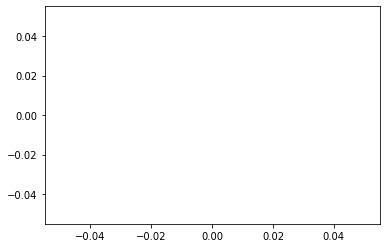

In [ ]:
x = np.array(range(len(mrr_bert))) + 1
plt.plot(x, np.array(mrr_vals1), label='batch-size-1')
plt.plot(x, np.array(mrr_vals4), label='batch-size-4')
plt.plot(x, np.array(mrr_bert), ':r', label='bert-base-uncased')
plt.plot(x, np.full(len(mrr_vals1), 1/len(mrr_vals1)), label='random')
plt.xlabel('Number of Paragraphs in Query')
plt.ylabel('Reciprocal Rank')
plt.legend(loc=0)